In [ ]:
import pandas as pd
import nltk
from nltk.stem.snowball import SnowballStemmer
import re
import math
import numpy as np
from numpy import dot
from numpy.linalg import norm
from scipy import spatial
import matplotlib.pyplot as plt
import pickle

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
def snow_ball_stemmer(data_list):
  stem = SnowballStemmer(language='english')
  return list(map(lambda word:stem.stem(word),data_list))

In [ ]:
def text_cleaner(data_str):
  data_str = data_str.strip(' ').lower()
  data_str = data_str
  new_str= ''
  for char in data_str:
    if char not in '''!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~''':
      new_str +=char
  return new_str.strip(' ')

In [ ]:

# Takes a list of words as parameter and returns a new list after removing the stopwords
def remove_stop_words(data_list):
  new_list = []
  for word in data_list:
    if word not in nltk.corpus.stopwords.words('english'):
      new_list.append(word)
  return new_list


In [ ]:
def preprocess(data):
  return remove_stop_words(nltk.word_tokenize(text_cleaner(data)))

In [ ]:
inverted_index = {}
# cat 3
# 'cat' = [1,2,5]

# Takes a term and its corresponding documentID and adds to the inverted index
def add_term_to_inverted_index(term,documentID):
  # an inverted index is a dict contained term,globalCount to posting list and each posting list contains ()
  try:
    # print(inverted_index[term]['count'])
    # inverted_index[term]['count']+=1 # increment the term count
    
    for document in inverted_index[term]['posting_list'].copy():
      if document['docID']>documentID:
      # if documentID in [i['docID'] for i in inverted_index[term]['posting_list']]:
        # we don't have that particular document in the posting list, add it
        inverted_index[term]['posting_list'].append({'docID':documentID,'count':1})
        inverted_index[term]['count']=len(inverted_index[term]['posting_list'])
        inverted_index[term]['posting_list'] = sorted(inverted_index[term]['posting_list'],key=lambda x:x['docID'])
        break
      elif document['docID']==documentID:
        document['count']+=1
        break
    
    else:
      inverted_index[term]['posting_list'].append({'docID':documentID,'count':1})
      inverted_index[term]['count']=len(inverted_index[term]['posting_list'])
      inverted_index[term]['posting_list'] = sorted(inverted_index[term]['posting_list'],key=lambda x:x['docID'])



  except KeyError:
    # print('we failed')
    # We are adding a term to our index keep the count empty and an empty list for the posting_list
    inverted_index[term]={'count':1,'posting_list':[{'docID':documentID,'count':1}]}
    # print(inverted_index)



In [ ]:
# for temp1 in inverted_index.copy().keys():
#   inverted_index[temp1]['count']=len(inverted_index[temp1]['posting_list'])

In [ ]:
# Convert all unknown attributes to NaN
dataframe_original = pd.read_csv('https://raw.githubusercontent.com/Rugvedhvaidya/Movie_Plots_Retrieval/main/wiki_movie_plots_deduped.csv')

dataframe = dataframe_original.replace(['Unknown','unknown'],'')
dataframe.drop('Wiki Page',1,inplace=True)


In [ ]:
# debug head(10)
total_doc=5000
retried_doc=30

for temp in dataframe.head(total_doc).iterrows():
  value = ''

  docID = temp[0]
 
  for temp_value in temp[1].to_dict().values():
    value+=str(temp_value)+' ' 

  value = value.replace('nan','')
  processed_list = preprocess(value)

  # change to a lemmatizer instead
  # print(snow_ball_stemmer(processed_list))
  # print(processed_list)
  for term in processed_list:
    add_term_to_inverted_index(term,docID)

  

In [ ]:
# inverted_index

{'1901': {'count': 4,
  'posting_list': [{'count': 1, 'docID': 0},
   {'count': 1, 'docID': 1},
   {'count': 1, 'docID': 2},
   {'count': 1, 'docID': 3}]},
 'kansas': {'count': 3,
  'posting_list': [{'count': 1, 'docID': 0},
   {'count': 1, 'docID': 35},
   {'count': 1, 'docID': 79}]},
 'saloon': {'count': 2,
  'posting_list': [{'count': 2, 'docID': 0}, {'count': 2, 'docID': 21}]},
 'smashers': {'count': 1, 'posting_list': [{'count': 1, 'docID': 0}]},
 'american': {'count': 100,
  'posting_list': [{'count': 1, 'docID': 0},
   {'count': 1, 'docID': 1},
   {'count': 1, 'docID': 2},
   {'count': 1, 'docID': 3},
   {'count': 1, 'docID': 4},
   {'count': 1, 'docID': 5},
   {'count': 1, 'docID': 6},
   {'count': 1, 'docID': 7},
   {'count': 1, 'docID': 8},
   {'count': 1, 'docID': 9},
   {'count': 1, 'docID': 10},
   {'count': 1, 'docID': 11},
   {'count': 1, 'docID': 12},
   {'count': 1, 'docID': 13},
   {'count': 1, 'docID': 14},
   {'count': 1, 'docID': 15},
   {'count': 1, 'docID': 16},


In [ ]:
# from pprint import pprint
# pprint(inverted_index)

In [ ]:
def idf_func(c):
  
  return math.log2(total_doc/c)


In [ ]:
def calc_idf():
  for term in inverted_index.keys():
    c=inverted_index[term]['count']
    idf_value=idf_func(c)
    inverted_index[term]['idf']=idf_value
calc_idf()


#CALCULATING TF-IDF SCORE

In [ ]:
tfidf_dict={}
tfidf_list=[]

for term in inverted_index.keys():
  tfidf_list.append(term)
  temp=inverted_index[term]['posting_list']
  for t in temp:
    tfidf_dict[t['docID'],term]=inverted_index[term]['idf']*(1+math.log2(t['count']))
    

# print(tfidf_dict)

In [ ]:
# from pprint import pprint
# pprint(tfidf_dict)

In [ ]:
D = np.zeros((total_doc,len(inverted_index)))
for i in tfidf_dict:
  k=tfidf_list.index(i[1])
  D[i[0]][k] = tfidf_dict[i]

#Calculating Cosine similarity

In [ ]:

def cosine_similarity1(query_dict):

 

  Q=  np.zeros((len(inverted_index)))
  res=[]
  
  for i in inverted_index.keys():
     k=tfidf_list.index(i)    
     if i in query_dict.keys():
       Q[k]=query_dict[i]

  
  for row in range(D.shape[0]):
    # print(row,"size:",row.shape)

    # print(Q,"Query Size:",Q.shape)

    # break
    #res.append(cosine_similarity(D[0],Q))
    result= 1 - spatial.distance.cosine(D[row], Q)
    res.append([row,result])
  
  return res
 
  # print(D)
  # print(Q)
  # print("Shape of D",D.shape)
  # print("shape of Q",Q.shape)


#ENTER THE QUERY


In [ ]:
query=input("Enter your query:-")
q_list= preprocess(query)

Enter your query:-woman young


In [ ]:
query_dict={}

# q_list=query.split()
#print(q_list)
for q in q_list:
  
  if q  in inverted_index.keys():
     query_dict[q]=(inverted_index[q]['idf'])*(1+math.log2(q_list.count(q)))

  
  

   
res=cosine_similarity1(query_dict)
sorted_res= sorted(res,key=lambda x:x[1],reverse=True)
# print(res,'\n')
# print(sorted_res,'\n')

#Displaying the retrived documents

In [ ]:
pd.set_option('display.max_colwidth', None)
dataframe.iloc[[docid[0] for docid in sorted_res]].head(retried_doc)

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Plot
340,1920,Now or Never,American,"Fred C. Newmeyer, Hal Roach","Harold Lloyd, Mildred Davis",comedy,"A young woman, who is employed as a nanny to a lonesome child named Dolly, is preparing to take a vacation which will include a long-awaited reunion with her childhood sweetheart. Her employers are a busy couple who have no time for their small daughter, so the nanny decides—without seeking their permission—to take Dolly with her on her vacation.\nMeanwhile, the young man she is to meet with races through the countryside by automobile on his way to his appointment. He crashes into a barn, loses his money to a tramp, and must complete his journey riding as a stowaway on the undercarriage of a train. After the couple meet, they and the child board a train. The woman has tickets for herself and Dolly, but the man has no ticket and no money.\nThe young woman discovers to her horror that her young charge's father is on the train. She does not want him to see her with Dolly, so she leaves the little girl with the young man and joins her employer in a separate coach. The young man is not an experienced babysitter, and caring for the child poses many challenges for him, especially as he must also evade the conductor.\nThe story ends happily: not only does Dolly's father approve of the young woman taking the little girl with her on her vacation, the young woman also discovers that her sweetheart is the man her employer was traveling to meet, as he has recently hired him for an important position."
400,1921,Now or Never,American,"Fred C. Newmeyer, Hal Roach","Harold Lloyd, Mildred Davis",comedy,"A young woman, who is employed as a nanny to a lonesome child named Dolly, is preparing to take a vacation which will include a long-awaited reunion with her childhood sweetheart. Her employers are a busy couple who have no time for their small daughter, so the nanny decides—without seeking their permission—to take Dolly with her on her vacation.\nMeanwhile, the young man she is to meet with races through the countryside by automobile on his way to his appointment. He crashes into a barn, loses his money to a tramp, and must complete his journey riding as a stowaway on the undercarriage of a train. After the couple meet, they and the child board a train. The woman has tickets for herself and Dolly, but the man has no ticket and no money.\nThe young woman discovers to her horror that her young charge's father is on the train. She does not want him to see her with Dolly, so she leaves the little girl with the young man and joins her employer in a separate coach. The young man is not an experienced babysitter, and caring for the child poses many challenges for him, especially as he must also evade the conductor.\nThe story ends happily: not only does Dolly's father approve of the young woman taking the little girl with her on her vacation, the young woman also discovers that her sweetheart is the man her employer was traveling to meet, as he has recently hired him for an important position."
4331,1946,The Spider Woman Strikes Back,American,Arthur Lubin,"Gale Sondergaard, Kirby Grant, Brenda Joyce",horror,"A young woman comes to a small rural town to serve as secretary for a blind woman, the town's wealthiest person. The town is awash in mystery owing to the inexplicable deaths of local ranchers' cattle. The young woman becomes entangled in a web of horror as she discovers that her employer, aided by the hideously deformed household servant, have used the blood of her predecessors to create a death serum when it is mixed with spider venom - and that her own blood is now being harvested at night, while she is in a drugged sleep, to continue the experiment."
1240,1931,The Woman Between,American,Victor Schertzinger,"Lili Damita, Lester Vail",drama,A young man returns from Europe after several years' estrangement from his family caused by his disapproval of his father's remarrying after his moth

# Relavence feedback
## Recall and Precision
## Recall = #(relevant retrieved)/#(relevant) -> tp/tp+fn

## Precision = #(relevant retrieved)/#(retrieved) -> tp/tp+fp


In [ ]:
print('Enter 1 if the document is relevant\n      0 if the document is irrelevant')
feedback=[]
for f in range(retried_doc):
  print('Is the document', f ,'relevant')
  x=int(input(0))
  feedback.append(x)

Enter 1 if the document is relevant
      0 if the document is irrelevant
Is the document 0 relevant
1
Is the document 1 relevant
1
Is the document 2 relevant
1
Is the document 3 relevant
1
Is the document 4 relevant
1
Is the document 5 relevant
0
Is the document 6 relevant
0
Is the document 7 relevant
1
Is the document 8 relevant
0
Is the document 9 relevant
1
Is the document 10 relevant
1
Is the document 11 relevant
1
Is the document 12 relevant
1
Is the document 13 relevant
1
Is the document 14 relevant
1
Is the document 15 relevant
1
Is the document 16 relevant
0
Is the document 17 relevant
1
Is the document 18 relevant
0
Is the document 19 relevant
0
Is the document 20 relevant
1
Is the document 21 relevant
1
Is the document 22 relevant
1
Is the document 23 relevant
1
Is the document 24 relevant
1
Is the document 25 relevant
1
Is the document 26 relevant
1
Is the document 27 relevant
1
Is the document 28 relevant
0
Is the document 29 relevant
1



### Enter 1 if the document is relevant
### Enter 0 if the document is irrelevant

In [ ]:
def evaluate(feedback):
  retrieved=30
  recall=[]
  precision=[]
  relevant=feedback.count(1) 
  relavent_count=0
  for ct in range(retried_doc):
  
    if feedback[ct]==1:
      relavent_count+=1;
    recall.append(relavent_count/relevant)
    precision.append(relavent_count/(ct+1))
  print("RECALL",recall)
  print("PRECISION",precision)
  plt.xlabel("RECALL")
  plt.ylabel("PRECISION")
  plt.title("P-R Curve")
  plt.plot(recall,precision)


RECALL [0.043478260869565216, 0.08695652173913043, 0.13043478260869565, 0.17391304347826086, 0.21739130434782608, 0.21739130434782608, 0.21739130434782608, 0.2608695652173913, 0.2608695652173913, 0.30434782608695654, 0.34782608695652173, 0.391304347826087, 0.43478260869565216, 0.4782608695652174, 0.5217391304347826, 0.5652173913043478, 0.5652173913043478, 0.6086956521739131, 0.6086956521739131, 0.6086956521739131, 0.6521739130434783, 0.6956521739130435, 0.7391304347826086, 0.782608695652174, 0.8260869565217391, 0.8695652173913043, 0.9130434782608695, 0.9565217391304348, 0.9565217391304348, 1.0]
PRECISION [1.0, 1.0, 1.0, 1.0, 1.0, 0.8333333333333334, 0.7142857142857143, 0.75, 0.6666666666666666, 0.7, 0.7272727272727273, 0.75, 0.7692307692307693, 0.7857142857142857, 0.8, 0.8125, 0.7647058823529411, 0.7777777777777778, 0.7368421052631579, 0.7, 0.7142857142857143, 0.7272727272727273, 0.7391304347826086, 0.75, 0.76, 0.7692307692307693, 0.7777777777777778, 0.7857142857142857, 0.7586206896551

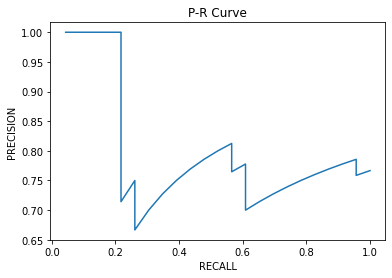

In [ ]:
evaluate(feedback)

#Non Trivial Tasks

Filtering movies based on release year

In [ ]:

# enter filters in the query string using /. Example:- classical singer /year 1950 
def query_with_filters(q_string):
  arr = q_string.split(' ')
  try:
    year_index = arr.index('/year')
    if arr[year_index+1].isdigit():
      input_dataframe = dataframe[dataframe['Release Year']==int(arr[year_index+1])]
      q_string = " ".join(arr[:year_index])
      arr =arr[:year_index]
    # return query,input_dataframe
    
  except ValueError:
    pass


  try:
    arr = q_string.split(' ')
    year_index = arr.index('/genre')
    if arr[year_index+1]:
      input_dataframe = dataframe[dataframe['Genre']==str(arr[year_index+1]).lower()]
      query = " ".join(arr[:year_index])
      return query,input_dataframe
  except ValueError:
    pass


  return q_string,input_dataframe

In [ ]:
print(query_with_filters('classical singer /year 1950 /genre drama'))

('classical singer',        Release Year  ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           